# **0. 준비**

본 코드는 최종 모델링 결과를 활용한 프로그램 개발 코드이다.

앞서 품종별로 상관분석과 요인분석을 진행한 여러 모델 중, 하나의 모델을 선택하여 최종 모델로 선택하여, 본 프로그램 개발에서 사용자의 사과 품질 예측에 사용하였다.

후지와 홍로 모두 **요인분석으로 진행된 모델이 최종 모델**로 선택되었으며, 후지는 **randomforest** 모델이며 홍로는 **xgboost** 모델이다.

### 1) 요인분석 모델을 선택한 이유


1) 요인분석을 통해 더 많은 변수를 축약하여 모델에 입력할 수 있었고, 따라서 더 많은 기상요인을 고려하게 되어 성능이 상관분석 보다 좋았다.

2) 본 대회의 데이터가 수확 일자와 수확 지역이 같아 중복데이터가 많다는 것을 고려할 때, 상관분석으로 주어진 데이터로만 품질간의 관계를 나타내는 것은 어렵다고 판단되어 요인분석의 성능이 좋았던 것으로 분석된다.



### 2) 필요한 추가 패키지 install

In [1]:
%pwd

'/home/work/.data/code'

API 인증키

- zCUqeziYTc6lKns4mF3OYQ
- fWXmtcJwQPGl5rXCcNDxGA

In [2]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install shap
import shap

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import numpy as np
import datetime
import pandas as pd
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import urllib.request
import requests
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import folium
from IPython.display import HTML
import matplotlib

warnings.filterwarnings('ignore')

plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

from matplotlib import font_manager, rc

In [6]:
!pip install --upgrade beautifulsoup4
from bs4 import BeautifulSoup

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
!pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
#인증키
authKey = 'zCUqeziYTc6lKns4mF3OYQ'

---

# **1. 사용자 날씨 데이터 불러오기**

기상청 API 허브 사이트 활용하여 사용자가 날짜와 장소를 입력하면, 기상데이터를 자동으로 불러올 수 있도록 한다. (https://apihub.kma.go.kr/)

요인분석 결과로 모델링에 사용한 변수들을 모두 불러와야한다.

필요한 변수들이 존재하는 경로가 모두 다르기 때문에 각각 불러온 후, 데이터 프레임을 하나로 병합하는 방법을 사용하였다.

## 1) 날씨 데이터 프레임(1)


- 월별요약자료에서 '일조율' 변수 불러오기

In [9]:
# 날씨 데이터프레임 생성 프로그램(1)
def weather_df_1(year, month, day, place):

    # 장소 변환
    place_to_place = {
        '화성': '수원',
        '포천': '동두천',
        '김제': '전주',
        '완주': '전주',
        '남해': '남해',
        '충주': '충주',
        '춘천': '북춘천',
        '군위': '대구'
    }

    my_place = place_to_place.get(place)

    month_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

    result_df = pd.DataFrame()

    if day <= 15:
        my_month = month - 1
    else:
        my_month = month

    for i in range(12):

        if (i+1) < my_month :
            my_year = year
        else:
            my_year = year - 1

        # API 주소
        url = "https://apihub.kma.go.kr/api/typ02/openApi/SfcMtlyInfoService/getMmSumry"

        # 파라미터 설정
        params = {
            "pageNo": 1,
            "numOfRows": 10,
            "dataType": "XML",
            "year": my_year,
            "month": month_list[i],
            "authKey": authKey
        }

        # API 요청 보내기
        response = requests.get(url, params=params)

        # 응답 데이터 추출
        xml_data = response.text

        # BeautifulSoup 객체 생성
        soup = BeautifulSoup(xml_data, 'html.parser')

        # 태그 제거한 텍스트 가져오기
        text = soup.get_text()

        # 빈 줄을 기준으로 데이터를 분할
        blocks = text.strip().split('\n\n')

        if not blocks:
            print("API 응답 데이터가 비어 있습니다.")

        data = blocks[1:]
        data[0] = '\n' + data[0]

        # 데이터를 줄 바꿈 문자('\n')을 기준으로 나누고, 빈 문자열을 제거
        data = [item.split('\n') if item.strip() else [np.nan] for item in data]

        # 데이터프레임으로 변환
        df = pd.DataFrame(data)

        df.drop(0, axis=1, inplace=True)

        df.columns = [
            "stnid", "stnko", "pa", "ps", "avgtamax", "avgtamin", "taavg", "tamax", "tamin",
            "avgtgmin", "ta", "tmmax", "tmmin", "maxcnt", "mincnt", "avghm", "avgcatot",
            "sumssday", "avgte05", "daydur"
        ]

        # 인덱스를 재설정
        df.reset_index(drop=True, inplace=True)

        df = df[df['stnko'] == my_place]
        df.index = [month_list[i]+'월']

        result_df = pd.concat([result_df, df], ignore_index=False)

    columns_to_select = ['daydur']
    result_df = result_df[columns_to_select]
    result_df = result_df.replace('null', float('nan'))

    return result_df

## 2) 날씨 데이터 프레임(2)

- 일별요약자료를 이용하여 평균 및 합계를 계산한 후, 평균기온('ta'), 평균최고기온('ta_max'), 평균최저기온('ta_min'), 평균상대습도('hm'), 평균풍속('ws'), 합계강수량('rn_day') 변수 불러오기



In [10]:
# 날씨 데이터프레임 생성 프로그램(2)
def weather_df_2(year, month, day, place):

    # 장소(place)와 대응하는 station_number를 매핑한 딕셔너리
    # 장소에 대한 번호는 API 기상청 데이터 참고
    place_to_station = {
        '화성': 119,
        '포천': 98,
        '김제': 146,
        '완주': 146,
        '남해': 295,
        '충주': 127,
        '춘천': 93,
        '군위': 143
    }

    # 딕셔너리를 사용하여 place를 station_number로 매핑
    station_number = place_to_station.get(place)

    if day <= 15:
        my_month = month - 1
    else:
        my_month = month

    result = pd.Series() # 마지막에 첫번째 열 제외시키기.
    month_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

    # API 주소
    url = "https://apihub.kma.go.kr/api/typ02/openApi/SfcMtlyInfoService/getDailyWthrData"

    for i in range(12):

        if (i+1) < my_month :
            my_year = year
        else:
            my_year = year - 1

        number =  str(i+1).zfill(2) # 월을 두자리 정수로 설정

        # 파라미터 설정
        params = {
            "pageNo": 1,
            "numOfRows": 10,
            "dataType": "XML",
            "year": my_year,
            "month": number,
            "station": station_number,
            "authKey": authKey
        }

        # API 요청 보내기
        response = requests.get(url, params=params)
        # 응답 데이터 추출
        xml_data = response.text
        # BeautifulSoup 객체 생성
        soup = BeautifulSoup(xml_data, 'html.parser')

        # 태그 제거한 텍스트 가져오기
        text = soup.get_text()
        text = text[22:]
        data = text

        # 빈 줄을 기준으로 데이터를 분할
        blocks = data.strip().split('\n\n')

        data = blocks[1:]
        data[0] = '\n' + data[0]

        # 데이터를 줄 바꿈 문자('\n')을 기준으로 나누고, 빈 문자열을 제거
        data = [item.split('\n') if item.strip() else [np.nan] for item in data]

        # 데이터프레임으로 변환
        df = pd.DataFrame(data)

        df.drop(0, axis=1, inplace=True)

        df = df.iloc[:,:19]
        df.columns = ['tm', 'ps', 'ta', 'ta_max', 'ta_min', 'td', 'tg_min', 'hm', 'hm_min', 'ev_s', 'ws', 'ws_max', 'wd_max', 'ca_tot', 'ss_day', 'si_day', 'rn_day', 'sd_new', 'sd_max']
        df.reset_index(drop=True, inplace=True)
        df.index = df.iloc[:,0].tolist()

        df = df.iloc[:, 1:]
        df = df.iloc[:-5, :]
        if len(df) >= 33:
            df = df.iloc[3:, :]
        else: pass

        # 필요한 변수만 남기기
        columns_to_select = ['ta', 'ta_max', 'ta_min', 'hm','ws', 'rn_day']
        df = df[columns_to_select]
        # 'null' 문자열을 NaN으로 대체
        df = df.replace('null', float('nan'))

        # 'wd_max' 열을 제외한 모든 열을 부동 소수점(float)으로 변환
        columns_to_convert = [col for col in df.columns if col != 'wd_max']
        df[columns_to_convert] = df[columns_to_convert].astype(float)
        df['rn_day'].fillna(0, inplace=True)

        a =  pd.Series(df['rn_day'].sum(), index=['rn_day'])
        columns_mean = [col for col in df.columns if col != 'rn_day']
        b = df[columns_mean].mean()
        c = pd.concat([b, a], axis=0)

        result = pd.concat([result, c], axis=1)

    new_result = result.iloc[:, 1:]
    new_result.index = ['ta', 'ta_max', 'ta_min', 'hm', 'ws', 'rn_day']
    new_result.columns = [month + '월' for month in month_list]

    return new_result.T

## 3) 날씨 데이터 프레임(3)

* 저장된 csv 파일에서 합계일사량, 평균지면온도 불러오기

 - weather_add : 합계일사랑, 평균지면온도가 월별로 저장되어 있는 데이터

In [11]:
# 날씨 데이터프레임 생성 프로그램(3) - 합계 일사량, 평균지면온도
def weather_df_3(year, month, day, place):
    place_mapping = {
    '화성': '수원',
    '포천': '동두천',
    '김제': '전주',
    '완주': '전주',
    '남해': '남해',
    '충주': '충주',
    '춘천': '북춘천',
    '군위': '대구'
    }
    place = place_mapping.get(place, place)

    def convert_date(date_str):
        year, month = date_str.split('-')
        return f'{year}-{month}'

    weather_add = pd.read_csv("/home/work/.data/data/weather_add.csv",encoding='cp949')
    # null 값 평균으로 대체
    weather_add[['합계 일사량(MJ/m2)', '평균지면온도(°C)']] = weather_add[['합계 일사량(MJ/m2)', '평균지면온도(°C)']].fillna(weather_add.mean())
    weather_add['일시'] = weather_add['일시'].apply(convert_date)
    weather_add['연도'] = weather_add['일시'].str.split('-').str[0].astype(int)
    weather_add['월'] = weather_add['일시'].str.split('-').str[1].astype(int)
    weather_add = weather_add[weather_add['지점명']==place]

    # day가 15보다 큰지 여부를 확인하여 시작 날짜 계산
    if day <= 15:
        start_date = datetime(year - 1, month, 1)  # 입력 연도와 월의 12개월 전
        end_date = datetime(year, month, 1)        # 입력 연도와 월
    else:
        start_date = datetime(year - 1, month + 1, 1)  # 입력 연도와 월의 11개월 전
        end_date = datetime(year, month + 1, 1)        # 입력 연도와 월

    weather_add = weather_add[
        (weather_add['일시'].apply(lambda x: datetime.strptime(f'{x}', '%Y-%m')) >= start_date) &
        (weather_add['일시'].apply(lambda x: datetime.strptime(f'{x}', '%Y-%m')) < end_date)
    ]

    weather_add = weather_add.sort_values(by='월')
    weather_add = weather_add[['합계 일사량(MJ/m2)', '평균지면온도(°C)']]
    weather_add.reset_index(drop=True, inplace=True)
    weather_add.index = ['01월', '02월', '03월', '04월', '05월', '06월', '07월', '08월', '09월', '10월', '11월', '12월']

    return weather_add

---

# **2. 사용자 데이터 프레임 완성**

## 1) 세 데이터 프레임 병합

먼저, 위에서 각각 다른 방법으로 불러온 사용자 날씨 데이터를 모두 병합하여 하나의 프레임으로 만들어준다.



In [12]:
# 세개의 데이터프레임 합치기
def concat_weather_df(year, month, day, place):
    df1 = weather_df_1(year, month, day, place)
    df2 = weather_df_2(year, month, day, place)
    df3 = weather_df_3(year, month, day, place)

    # df1과 df2 합치기
    weather_df = pd.concat([df1, df2], axis=1)
    weather_df.columns = ['일조율(%)', '평균 기온(°C)', '평균 최고기온(°C)', '평균 최저기온(°C)',
                          '평균 상대습도(%)', '평균풍속(m/s)', '월합강수량(00~24h만)(mm)']

    weather_df = pd.concat([weather_df, df3], axis=1)

    new_order = [
    '평균 기온(°C)', '평균 최고기온(°C)', '평균 최저기온(°C)', '평균 상대습도(%)',
    '월합강수량(00~24h만)(mm)', '평균풍속(m/s)', '일조율(%)', '합계 일사량(MJ/m2)',
    '평균지면온도(°C)'
    ]
    weather_df = weather_df[new_order]

    return weather_df

## 2) 최종 프레임을 가공할 함수 생성

아래 함수는 다음과 과정을 거쳐 작동된다.

\

(1) 조사일로부터 12개월 전의 모든 기상데이터를 하나의 데이터로 만들어준다.

(2) csv 파일(weather_add2)에서 연도별 태풍, 장마, 폭염 변수를 불러와 병합시킨다.

(3) 사과의 품종인 후지와 홍로에 따른 스케일링을 각각 적용한다.

(4) 요인분석 결과를 이용한 최종 요인분석 데이터 프레임을 만들어준다.

In [13]:
def test_df(year,month,day,place, apple_type):
    df = concat_weather_df(year, month, day, place)
    result = df.values.flatten()

    # 결과를 담을 데이터
    data = pd.DataFrame()

    for i in range(12):
        j = i*9
        month_data = {
            f'{i+1}월 평균 기온(°C)': result[j],
            f'{i+1}월 평균 최고기온(°C)': result[j + 1],
            f'{i+1}월 평균 최저기온(°C)': result[j + 2],
            f'{i+1}월 평균 상대습도(%)': result[j + 3],
            f'{i+1}월 월합강수량(00~24h만)(mm)': result[j + 4],
            f'{i+1}월 평균풍속(m/s)': result[j + 5],
            f'{i+1}월 일조율(%)': result[j + 6],
            f'{i+1}월 합계 일사량(MJ/m2)': result[j + 7],
            f'{i+1}월 평균지면온도(°C)': result[j + 8],
        }
        month_data_df = pd.DataFrame(month_data, index=[0])  # 데이터를 DataFrame으로 변환
        data = pd.concat([data, month_data_df], axis=1)

    # 추가 기상데이터 불러오기(연도별 태풍, 장마, 폭염 변수)
    weather_add2 = pd.read_excel("/home/work/.data/data/weather_add2.xlsx")
    weather_add2 = weather_add2[(weather_add2['조사연도']==year) & (weather_add2['지점명']==place)].iloc[:,2:]
    weather_add2 = weather_add2.fillna(weather_add2.mean())
    weather_add2.reset_index(drop=True, inplace=True)

    # 최종 데이터 합치기
    test_df = pd.concat([data, weather_add2], axis=1)

    # 스케일링에 이용할 데이터프레임 가져오기
    if apple_type == '후지' :
        X_train = pd.read_excel("/home/work/.data/data/X_train_fuji.xlsx") # 후지 데이터
    else :
        X_train = pd.read_excel("/home/work/.data/data/X_train_red.xlsx") # 홍로 데이터

    X_train = X_train[test_df.columns]

    # Train 데이터로 스케일러 학습
    standard_scaler = StandardScaler()
    stan_fit = standard_scaler.fit(X_train)
    test_scaled = stan_fit.transform(test_df)

    scale_columns = X_train.columns
    result_df = pd.DataFrame(test_scaled, columns=scale_columns)

    # 요인분석을 위한 데이터프레임 만들기
    final_df = pd.DataFrame()
    final_df['1_2월 온도'] = result_df[['2월 평균 기온(°C)', '2월 평균지면온도(°C)', '1월 평균 기온(°C)', '2월 평균 최저기온(°C)', '1월 평균지면온도(°C)']].mean(axis=1)
    final_df['평균풍속'] = result_df[['2월 평균풍속(m/s)', '1월 평균풍속(m/s)', '3월 평균풍속(m/s)', '5월 평균풍속(m/s)', '12월 평균풍속(m/s)', '11월 평균풍속(m/s)', '4월 평균풍속(m/s)']].mean(axis=1)
    final_df['7월의 기온'] = result_df[['7월 평균 최고기온(°C)', '7월 평균 기온(°C)', '7월 평균 최저기온(°C)', '7월 평균지면온도(°C)']].mean(axis=1)
    final_df['5월의 기온'] = result_df[['5월 일조율(%)', '5월 평균지면온도(°C)', '5월 평균 최고기온(°C)']].mean(axis=1)
    final_df['평균 상대 습도'] = result_df[['10월 평균 상대습도(%)', '9월 평균 상대습도(%)', '3월 평균 상대습도(%)', '6월 평균 상대습도(%)', '8월 평균 상대습도(%)', '7월 평균 상대습도(%)', '4월 평균 상대습도(%)', '5월 평균 상대습도(%)']].mean(axis=1)
    final_df['11월_12월 일조율'] = result_df[['11월 일조율(%)', '12월 일조율(%)']].mean(axis=1)
    final_df['6월 기온'] = result_df[['6월 평균 최고기온(°C)', '6월 평균 기온(°C)', '6월 평균지면온도(°C)']].mean(axis=1)
    final_df['8월 온도'] = result_df[['8월 평균 최고기온(°C)', '8월 평균지면온도(°C)', '8월 평균 기온(°C)', '8월 일조율(%)']].mean(axis=1)
    final_df['합계일사량'] = result_df[['2월 합계 일사량(MJ/m2)', '1월 합계 일사량(MJ/m2)', '5월 합계 일사량(MJ/m2)','6월 합계 일사량(MJ/m2)',  '12월 합계 일사량(MJ/m2)', '4월 합계 일사량(MJ/m2)','7월 합계 일사량(MJ/m2)', '8월 합계 일사량(MJ/m2)',  '9월 합계 일사량(MJ/m2)','10월 합계 일사량(MJ/m2)','3월 합계 일사량(MJ/m2)', '11월 합계 일사량(MJ/m2)']].mean(axis=1)
    final_df['10_12월 월합강수량'] = result_df[['12월 월합강수량(00~24h만)(mm)', '10월 월합강수량(00~24h만)(mm)']].mean(axis=1)
    final_df['기타'] = result_df[['3월 일조율(%)', '6월 월합강수량(00~24h만)(mm)', '8월 평균 최저기온(°C)','2월 평균 최고기온(°C)']].mean(axis=1)
    final_df['9월 일조율'] = result_df[['9월 일조율(%)']].mean(axis=1)
    final_df['9월 온도'] = result_df[['9월 평균 기온(°C)', '9월 평균 최저기온(°C)', '9월 평균 최고기온(°C)']].mean(axis=1)
    final_df['12_1_2_4월 일조율'] = result_df[['2월 일조율(%)', '4월 일조율(%)', '1월 일조율(%)', '12월 일조율(%)']].mean(axis=1)

    final_df = pd.concat([final_df, result_df.iloc[:,-5:]], axis=1)

    return final_df

---

# **3. 예측 프로그램**

- 사용자에게 제배 지점, 사과 종류(후지, 홍로), 수확 날짜를 입력받는다.

- '홍로_요인분석', '후지_요인분석' 코드 파일에서 예측 모델을 저장하여 불러온 후  사용자의 품질 예측에 사용한다.

해당 프로그램은 사용자가 제배했던 사과 수확일을 입력하면, 해당 사과의 품질을 예측해주며 사용자의 사과가 각 품질에 해당할 확률도 함께 출력한다. 뿐만 아니라 shap을 사용하여 사용자의 데이터에 대해 어떤 변수가 품질에 얼마만큼의 영향을 미치는지 출력해주며, 동시에 다른 지역의 품질도 함께 지도에 그려 비교할 수 있도록 한다.




In [14]:
def apple_quality_program():

    print('안녕하세요. 사과 품질 예측기입니다.\n')

    # 지점
    while True:
        place = input('▶ 지점을 입력하세요(화성, 포천, 김제, 완주, 남해, 충주, 춘천, 군위): ')

        if place not in ['화성', '포천', '김제', '완주', '남해', '충주', '춘천', '군위']:
            print("⚠️위에 있는 지역들만 가능합니다.\n")
            continue
        break

    # 사과 종류
    while True:
        apple_type = input('\n▶ 사과 종류를 입력하세요(후지, 홍로): ')

        if apple_type not in ['후지', '홍로']:
            print("⚠️위에 있는 사과 종류들만 가능합니다.\n")
            continue
        break

    # 수확 날짜
    while True:
        date = input('\n▶ 수확 날짜를 입력하세요(yyyy/MM/DD 형식): ')
        # '/' 문자를 기준으로 문자열을 나눕니다.
        date_parts = date.split('/')
        if len(date_parts) != 3: # 년, 월, 일을 모두 입력하지 않은 경우
            print("⚠️날짜 형식이 올바르지 않습니다. '년/월/일' 형식으로 입력해주세요.\n")
            continue

        year, month, day = date_parts
        try: # 숫자로 처리할 수 없는 값이 들어온 경우
            year = int(year)
            month = int(month)
            day = int(day)

        except ValueError:
            print("⚠️날짜 형식이 올바르지 않습니다. '년/월/일' 형식으로 입력해주세요.\n")
            continue

        # 연도와 월의 자리수를 확인
        if len(str(year)) != 4:
            print("⚠️연도는 4자리로 입력해주세요.\n")
            continue

        if place == '춘천':
            if year < 2018:
                print("⚠️춘천 지역은 2018년부터 입력 가능합니다.\n")
                continue
        else:
            if year < 2017:
                print("⚠️2017년부터 입력 가능한 지역입니다.\n")
                continue

        if apple_type == '후지':
            if month not in [10, 11]: # 10월 또는 11월이 아닌 경우
                print("⚠️10월 또는 11월 중 수확한 '후지' 사과만 품질 예측이 가능합니다.\n")
                continue
        elif apple_type == '홍로':
            if month not in [8, 9]: # 8월 또는 9월이 아닌 경우
                print("⚠️8월 또는 9월 중 수확한 '홍로' 사과만 품질 예측이 가능합니다.\n")
                continue
        break

    want_map = None
    while True:
      want_map = input('\n▶ 같은 날 수확한 다른 지점의 사과 품질도 함께 출력을 원하십니까?(5분 이상의 시간이 소요됩니다.(O,X)): ')
      break

    test_data = test_df(year, month, day, place,apple_type)

    if apple_type == '후지':
        # 모델 불러오기
        with open('/home/work/.data/model/fuji_rf_model.pkl', 'rb') as model_file:
            loaded_model = pickle.load(model_file)
    else:
        # 모델 불러오기
        with open('/home/work/.data/model/red_xgb_model.pkl', 'rb') as model_file:
            loaded_model = pickle.load(model_file)

    # 불러온 모델을 사용하여 예측 등을 수행
    predictions = loaded_model.predict(test_data)
    class_probabilities =  loaded_model.predict_proba(test_data)

    print('          \n')
    print(f"요청하신 {place}에서 생산된 {apple_type} 사과의 품질은 {predictions +1} 등급 입니다.")
    print('          \n')

    import warnings
    warnings.filterwarnings('ignore')
    plt.rc('font', family='NanumGothic')

    plt.figure(figsize=(10, 3))
    class_labels = ['1등급','2등급','3등급','4등급']
    heatmap = plt.imshow(class_probabilities, cmap='Pastel1', aspect='auto', vmin=0, vmax=1)
    plt.xticks(np.arange(len(class_labels)), class_labels)
    plt.yticks(np.arange(class_probabilities.shape[0]), ['예측 확률'])
    plt.colorbar(heatmap, label='확률')

    for i in range(class_probabilities.shape[0]):
        for j in range(class_probabilities.shape[1]):
            plt.text(j, i, f'{class_probabilities[i, j]:.3f}', ha='center', va='center', color='black', fontsize=12)

    plt.xlabel('등급')
    plt.title('품질이 각 등급이 될 확률')
    plt.show()

    for i in range(4):
        probability_percent = class_probabilities[0, i] * 100
        print(f'사과가 {i+1}등급일 확률은 {probability_percent:.1f}% 입니다.')

    # shap_values 구하기
    explainer = shap.TreeExplainer(loaded_model)
    shap_values = explainer.shap_values(test_data)

    #force plot
    shap.initjs()
    shap.force_plot(explainer.expected_value[int(predictions)], shap_values[int(predictions)][0],
                    test_data.values[0],matplotlib=True, feature_names = test_data.columns, text_rotation=45)
    plt.show()

    # print('   ')

    # # 유니코드에서 음수 부호 설정
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # plt.rcParams['axes.unicode_minus'] = False
    warnings.filterwarnings('ignore')
    shap.waterfall_plot(shap.Explanation(values=shap_values[int(predictions)][0],
                                        base_values=explainer.expected_value[int(predictions)], data=test_data.iloc[0],
                                        feature_names=test_data.columns.tolist()))
    plt.show()

    #지도 시각화를 위해 생성할 사용자 지점 외의 지점별 데이터프레임생성
    #지역리스트
    if want_map == 'O':
      place2= ['화성', '포천', '김제', '완주', '남해', '충주', '춘천', '군위']
      other_merged_df = pd.DataFrame()
      for i in place2:
        if place != i: #해당하지 않은 지역들에 대해서 다시 돌려주기
          other_test_data = test_df(year, month, day, i, apple_type)
          other_test_data['과원지점'] = i
          other_merged_df = pd.concat([other_merged_df, other_test_data])

      #test_data까지 해서 모든 데이터가 있는 프레임
      test_data['과원지점']= place
      merged_df = pd.concat([other_merged_df, test_data])

      #예측값 구해서 품질 칼럼에 넣기
      merge_predictions = loaded_model.predict(merged_df.loc[:, merged_df.columns != '과원지점'])
      merged_df['품질'] = merge_predictions

      # 과원지점의 주소를 이용하여 위도와 경도를 구해주었다.
      locations = {
        '화성': {'위도': 37.1753561, '경도': 126.7523506},
        '포천': {'위도': 38.038545, '경도': 127.1987814},
        '김제': {'위도': 35.8717396, '경도': 126.9627225},
        '완주': {'위도': 35.8334023, '경도': 127.035833},
        '남해': {'위도': 34.814053, '경도': 127.9418606},
        '충주': {'위도': 37.0699936, '경도': 127.9330636},
        '춘천': {'위도': 37.956079, '경도': 127.7452117},
        '군위': {'위도': 35.8294374, '경도': 128.5655119},
      }

      # '과원지점' 칼럼을 기반으로 위도와 경도 정보를 가져오기
      merged_df['위도'] = merged_df['과원지점'].map(lambda x: locations.get(x, {}).get('위도'))
      merged_df['경도'] = merged_df['과원지점'].map(lambda x: locations.get(x, {}).get('경도'))

      
      
      # 한반도의 중심 좌표를 사용하여 기본 지도를 생성
      m = folium.Map(location=[36.5, 127.5], zoom_start=7)

      for index, row in merged_df.iterrows():
        if row['품질'] == 0:
            color = 'red'
        elif row['품질'] == 1:
            color = 'orange'
        elif row['품질'] == 2:
            color = 'yellow'
        else:
            color = 'green'
            
        plt.rc('font', family='NanumGothic')
        
        folium.CircleMarker(
            location=[row['위도'], row['경도']],
            radius=15,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f'품질: {row["품질"]}'
        ).add_to(m)

        folium.Marker(location=[row['위도'], row['경도']], icon=None, popup=row['과원지점']).add_to(m)

      return m

안녕하세요. 사과 품질 예측기입니다.

▶ 지점을 입력하세요(화성, 포천, 김제, 완주, 남해, 충주, 춘천, 군위): 충주

▶ 사과 종류를 입력하세요(후지, 홍로): 후지

▶ 수확 날짜를 입력하세요(yyyy/MM/DD 형식): 2018/10/1

▶ 같은 날 수확한 다른 지점의 사과 품질도 함께 출력을 원하십니까?(5분 이상의 시간이 소요됩니다.(O,X)): O
          

요청하신 충주에서 생산된 후지 사과의 품질은 [3] 등급 입니다.
          



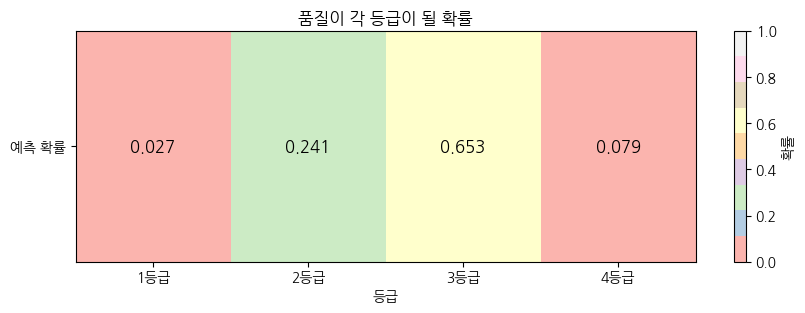

사과가 1등급일 확률은 2.7% 입니다.
사과가 2등급일 확률은 24.1% 입니다.
사과가 3등급일 확률은 65.3% 입니다.
사과가 4등급일 확률은 7.9% 입니다.


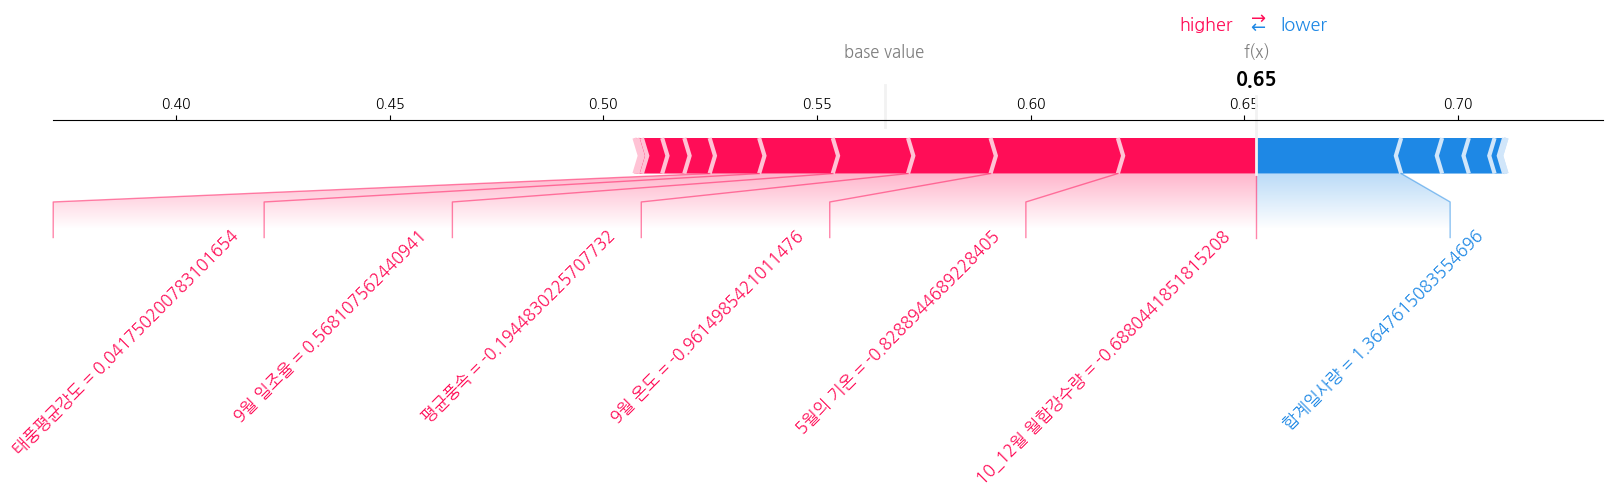

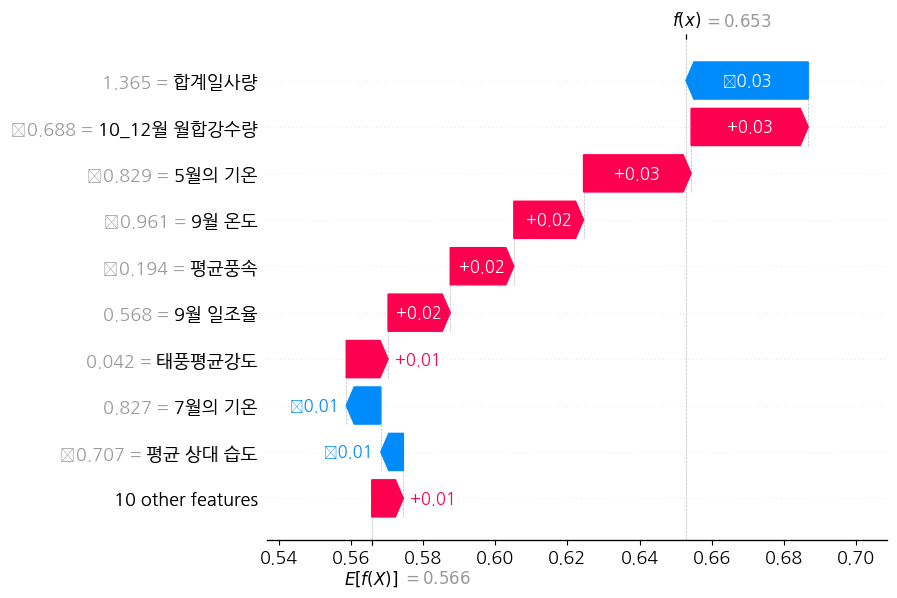

In [15]:
apple_quality_program()